Ket noi voi google drive

In [56]:
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse 

E: Package 'python-software-properties' has no installation candidate


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import cac thu vien can thiet

In [0]:
import numpy as np
import os
import shutil
import keras
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

Tao dataset 

In [0]:
image_dir = "/content/drive/My Drive/resnet/flowers/flowers"
def read_images_from_dir(base_dir, folder):
    path_folder = os.path.join(image_dir, folder)
    files_directory = os.listdir(path_folder)
    
    labels = []
    images = []
    for file in files_directory:
        if file.endswith('.jpg'):
            labels.append(folder)
            images.append(os.path.join(path_folder, file))
    return labels, images

def read_images(base_dir):
    labels = []
    images = []
    folders = os.listdir(image_dir)
    for folder in folders:
        labels_folder, images_folder = read_images_from_dir(base_dir, folder)
        labels.extend(labels_folder)
        images.extend(images_folder)
    return labels, images

labels, images = read_images(image_dir)

Hien thi moi so hinh anh mau

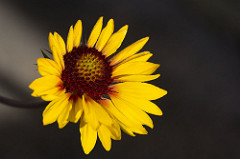

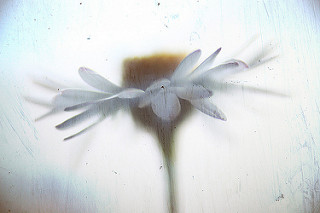

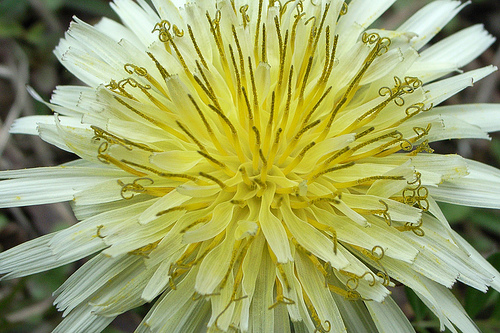

In [14]:
from random import randrange

for i in range(3):
    random_index = randrange(len(images))
    display(Image(images[random_index]))

Phan phoi du lieu: 70% train, 30% test

In [0]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=8, stratify=labels)

In [0]:
output_folder = '/content/drive/My Drive/resnet/output/'
train_folder = '/content/drive/My Drive/resnet/output/train'
test_folder = '/content/drive/My Drive/resnet/output/test'

def create_output_folders():
    if not os.path.exists(output_folder):
        print('Creating output directories')
        os.mkdir(output_folder)
        if not os.path.exists(train_folder):
            os.mkdir(train_folder)
            for label in set(labels):
                os.mkdir(train_folder + '/' + label)
        if not os.path.exists(test_folder):
            os.mkdir(test_folder)
            for label in set(labels):
                os.mkdir(test_folder + '/' + label)
            
def copy_files_to_train_and_validation_folders():            
    print('Copy training files to directory')
    for index, value in enumerate(images_train):
        dest = os.path.join(train_folder, labels_train[index])
        shutil.copy(value, dest)

    print('Copy test files to directory')        
    for index, value in enumerate(images_test):
        shutil.copy(value, test_folder + '/' + labels_test[index])
    
create_output_folders()
copy_files_to_train_and_validation_folders()

Tao mo hinh cho model

In [16]:
num_classes = len(set(labels))
resnet_weights_path = '/content/drive/My Drive/resnet/keras/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create model
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
model.add(Dense(num_classes, activation='softmax'))

# Do not train first layer (ResNet) as it is already pre-trained
model.layers[0].trainable = False

# Compile model 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


Tao cac checkpoint de lay model voi do chinh xac cao nhat co the

In [0]:
from keras.callbacks import *
filepath = "/content/drive/My Drive/resnet/checkpoint/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Tien hanh train model

In [24]:
output_folder = '/content/drive/My Drive/resnet/output/'
train_folder = '/content/drive/My Drive/resnet/output/train'
test_folder = '/content/drive/My Drive/resnet/output/test'
image_size = 224
data_generator_aug = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                        horizontal_flip=True, 
                                        width_shift_range=0.2, 
                                        height_shift_range=0.2)

train_generator = data_generator_aug.flow_from_directory(train_folder, 
                                                         target_size=(image_size, image_size), 
                                                         batch_size=24, 
                                                         class_mode='categorical')

validation_generator = data_generator_aug.flow_from_directory(test_folder, 
                                                              target_size=(image_size, image_size), 
                                                              class_mode='categorical')

model.fit_generator(train_generator, 
                    steps_per_epoch=100, 
                    validation_data=validation_generator,
                    validation_steps=1, 
                    epochs=20,
                    callbacks=callbacks_list)

Found 3031 images belonging to 5 classes.
Found 1297 images belonging to 5 classes.
Epoch 1/20
100/100 [==============================] - 76s 755ms/step - loss: 0.3728 - acc: 0.8671 - val_loss: 1.2170 - val_acc: 0.6562

Epoch 00001: val_acc improved from -inf to 0.65625, saving model to /content/drive/My Drive/resnet/checkpoint/epochs:001-val_acc:0.656.hdf5
Epoch 2/20
100/100 [==============================] - 43s 434ms/step - loss: 0.3010 - acc: 0.8967 - val_loss: 0.3557 - val_acc: 0.9375

Epoch 00002: val_acc improved from 0.65625 to 0.93750, saving model to /content/drive/My Drive/resnet/checkpoint/epochs:002-val_acc:0.938.hdf5
Epoch 3/20
100/100 [==============================] - 35s 349ms/step - loss: 0.3003 - acc: 0.8942 - val_loss: 0.8328 - val_acc: 0.6562

Epoch 00003: val_acc did not improve from 0.93750
Epoch 4/20
100/100 [==============================] - 35s 348ms/step - loss: 0.2869 - acc: 0.9021 - val_loss: 0.5390 - val_acc: 0.7500

Epoch 00004: val_acc did not improve fr

Luu model

In [0]:
model.save('/content/drive/My Drive/resnet/model/flower_resnet50.h5')

Tien hanh test thu de kiem tra model

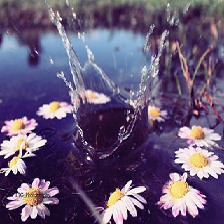

In [27]:
from keras.preprocessing import image
test_image =  image.load_img("/content/drive/My Drive/resnet/output/test/daisy/10172379554_b296050f82_n.jpg",target_size=(224, 224))
test_image

In [29]:
transformed_image = image.img_to_array(test_image)
transformed_image.shape

(224, 224, 3)

In [30]:
transformed_image = np.expand_dims(transformed_image, axis=0)
transformed_image.shape

(1, 224, 224, 3)

In [32]:
transformed_image = preprocess_input(transformed_image)
transformed_image

array([[[[ -89.619   , -101.558   , -107.619   ],
         [ -95.619   , -103.558   , -110.619   ],
         [-100.619   , -105.558   , -113.619   ],
         ...,
         [ -62.619003,  -65.558   ,  -86.619   ],
         [ -61.619003,  -61.558   ,  -83.619   ],
         [ -78.619   ,  -71.558   ,  -93.619   ]],

        [[ -91.619   , -101.558   , -106.619   ],
         [-107.619   , -113.558   , -119.619   ],
         [-115.619   , -119.558   , -126.619   ],
         ...,
         [ -46.619003,  -49.558   ,  -64.619   ],
         [ -89.619   ,  -90.558   , -106.619   ],
         [-100.619   ,  -94.558   , -110.619   ]],

        [[ -96.619   , -105.558   , -106.619   ],
         [-115.619   , -120.558   , -122.619   ],
         [-124.619   , -129.558   , -131.619   ],
         ...,
         [ -80.619   ,  -82.558   ,  -93.619   ],
         [-101.619   , -100.558   , -110.619   ],
         [-101.619   ,  -96.558   , -107.619   ]],

        ...,

        [[-200.619   , -222.558   , -1

In [54]:
from keras.models import load_model
model_flower = "/content/drive/My Drive/resnet/model/flower_resnet50.h5"
model = load_model(model_flower, compile=False)
y_pred = model.predict(transformed_image)
y_pred

array([[9.9529028e-01, 4.3947250e-03, 6.2614077e-07, 3.1308446e-04,
        1.3077179e-06]], dtype=float32)

In [35]:
y_pred.shape

(1, 5)

In [55]:
prediction = np.argmax(y_pred[0])
print('%s (%.2f%%)' % (labels[prediction], y_pred[0][prediction]*100 ))


daisy (99.53%)


Tien hanh danh gia model

In [101]:
from keras.preprocessing import image
from imutils import paths
import random
import pickle

dataset = "/content/drive/My Drive/resnet/output/test"

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(dataset)))
random.seed(10)
random.shuffle(imagePaths)
 
# initialize the data and labels
data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	img = image.load_img(imagePath, target_size=(224, 224))
	x = image.img_to_array(img)
	#x = np.expand_dims(x, axis=0)
	x = preprocess_input(x)
	data.append(x)
 
	# extract set of class labels from the image path and update the
	# labels list
	l = label = imagePath.split(os.path.sep)[-2]
	labels.append(l)

data = np.array(data)
labels = np.array(labels)
print(set(labels))

print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))


{'rose', 'daisy', 'tulip', 'sunflower', 'dandelion'}
[INFO] data matrix: 1297 images (762.64MB)


In [0]:
for i, label in enumerate(list(labels)):
  if label == 'daisy':
    labels[i] = 0
  if label == 'dandelion':
    labels[i] = 1
  if label == 'rose':
    labels[i] = 2
  if label == 'sunflower':
    labels[i] = 3
  if label == 'tulip':
    labels[i] = 4
labels = list(map(int, labels)) 

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(data, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report( y_true=labels,y_pred = y_pred_bool))

1297/1297 [==============================] - 5s 4ms/step
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       231
           1       0.93      0.86      0.90       316
           2       0.91      0.73      0.81       235
           3       0.81      0.95      0.87       220
           4       0.86      0.84      0.85       295

    accuracy                           0.85      1297
   macro avg       0.86      0.85      0.85      1297
weighted avg       0.86      0.85      0.85      1297



In [0]:
cnf_matrix = confusion_matrix(y_true = labels, y_pred = y_pred_bool)

Su dung confusion_matrix de danh gia model

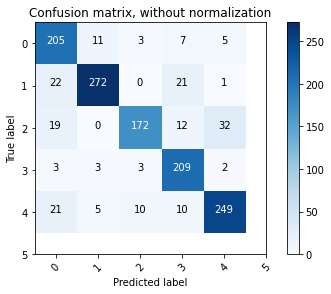

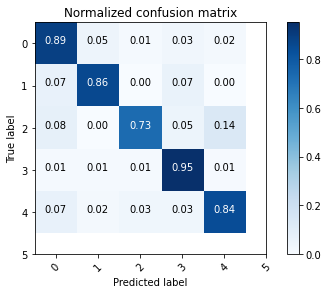

In [79]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = [0, 1, 2, 3, 4, 5]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()